# import library


In [1]:
import os
import sys
import traceback

import sys, os, time, argparse

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as nfunc
from torch.nn.parameter import Parameter

import random
import argparse
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import DataLoader


try:
    import cupy as cp
except ImportError:
    cp = None

import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import Variable, optimizers, cuda, serializers
import matplotlib.pyplot as plt

gpu = "1"

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu

# import model code

In [2]:
import chainer
import chainer.functions as F
from chainer import Variable, optimizers, cuda, serializers
%load_ext autoreload
%autoreload 2


from ExpUtils import *

from chainer_func.source.CostFunc import *
from chainer_func.source.utils import mkdir_p
from chainer_func.source.chainer_functions.misc import call_bn

# from chainer_func.models.cnn import CNN
from chainer_func.load_dataset import load_dataset


# CNN model

In [3]:
class CNN(chainer.Chain):
    def __init__(self, n_outputs=10, dropout_rate=0.5, top_bn=False):
        self.dropout_rate = dropout_rate
        self.top_bn = top_bn
        initializer = chainer.initializers.HeUniform(1.0)
        super(CNN, self).__init__(
            c1=L.Convolution2D(3, 128, ksize=3, stride=1, pad=1,
                                     initialW=initializer),
            c2=L.Convolution2D(128, 128, ksize=3, stride=1, pad=1,
                                     initialW=initializer),
            c3=L.Convolution2D(128, 128, ksize=3, stride=1, pad=1,
                                     initialW=initializer),
            c4=L.Convolution2D(128, 256, ksize=3, stride=1, pad=1,
                                     initialW=initializer),
            c5=L.Convolution2D(256, 256, ksize=3, stride=1, pad=1,
                                     initialW=initializer),
            c6=L.Convolution2D(256, 256, ksize=3, stride=1, pad=1,
                                     initialW=initializer),
            c7=L.Convolution2D(256, 512, ksize=3, stride=1, pad=0,
                                     initialW=initializer),
            c8=L.Convolution2D(512, 256, ksize=1, stride=1, pad=0,
                                     initialW=initializer),
            c9=L.Convolution2D(256, 128, ksize=1, stride=1, pad=0,
                                     initialW=initializer),
            l_cl=L.Linear(128, n_outputs,
                                     initialW=initializer),
            bn1=L.BatchNormalization(128),
            bn2=L.BatchNormalization(128),
            bn3=L.BatchNormalization(128),
            bn4=L.BatchNormalization(256),
            bn5=L.BatchNormalization(256),
            bn6=L.BatchNormalization(256),
            bn7=L.BatchNormalization(512),
            bn8=L.BatchNormalization(256),
            bn9=L.BatchNormalization(128),
        )
        if self.top_bn:
            self.add_link('bn_cl', L.BatchNormalization(n_outputs))

    def __call__(self, x, train=True, update_batch_stats=True):
        h = x
        h = self.c1(h)
        h = F.leaky_relu(call_bn(self.bn1, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = self.c2(h)
        h = F.leaky_relu(call_bn(self.bn2, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = self.c3(h)
        h = F.leaky_relu(call_bn(self.bn3, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        if self.dropout_rate > 0.01:
            h = F.dropout(h, ratio=self.dropout_rate)

        h = self.c4(h)
        h = F.leaky_relu(call_bn(self.bn4, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = self.c5(h)
        h = F.leaky_relu(call_bn(self.bn5, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = self.c6(h)
        h = F.leaky_relu(call_bn(self.bn6, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = F.max_pooling_2d(h, ksize=2, stride=2)
        if self.dropout_rate > 0.01:
            h = F.dropout(h, ratio=self.dropout_rate)

        h = self.c7(h)
        h = F.leaky_relu(call_bn(self.bn7, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = self.c8(h)
        h = F.leaky_relu(call_bn(self.bn8, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = self.c9(h)
        h = F.leaky_relu(call_bn(self.bn9, h, test=not train, update_batch_stats=update_batch_stats), slope=0.1)
        h = F.average_pooling_2d(h, ksize=h.data.shape[2])
        logit = self.l_cl(h)
        if self.top_bn:
            logit = call_bn(self.bn_cl, logit, test=not train, update_batch_stats=update_batch_stats)
        return logit

# train function

In [4]:
def train(args):
    np.random.seed(1)
    train_l, train_ul, test = load_dataset(args.data_dir, valid=args.validation, dataset_seed=args.dataset_seed)
    wlog("N_train_labeled:{}, N_train_unlabeled:{}".format(train_l.N, train_ul.N))
    print("train data", train_l.data.sum())
    
    np.random.seed(1)
    enc = CNN(n_outputs=args.n_categories, dropout_rate=args.dropout_rate, top_bn=args.top_bn)
    if args.gpu > -1:
        enc.to_gpu()

    optimizer = optimizers.Adam(alpha=args.lr, beta1=args.mom1)
    optimizer.setup(enc)
    optimizer.use_cleargrads()

    accs_test = np.zeros(args.num_epochs)

    iter_no = 0
    start = time.time()
    cp.random.seed(1)
    np.random.seed(1)
    
    for epoch in range(args.num_epochs):
        for it in range(args.num_batch_it):
            with chainer.using_config("train", True):
                x, t = train_l.get(args.batchsize, gpu=args.gpu, aug_trans=args.aug_trans, aug_flip=args.aug_flip)
                loss_l = loss_labeled(enc, Variable(x), t, args)

                if args.method == "ce":
                    loss_total = loss_l
                    loss_ul = 0
                else:
                    x_u, _ = train_ul.get(args.batchsize_ul, gpu=args.gpu, aug_trans=args.aug_trans, aug_flip=args.aug_flip)
                    loss_ul = loss_unlabeled(enc, Variable(x_u), None, args, Variable(x), Variable(t))
                    loss_total = loss_l + loss_ul

                enc.cleargrads()
                loss_total.backward()
                optimizer.update()
#             if epoch == 0:
#                 print("x: %.5f" % x.sum())
        if epoch % 1 == 0 and it == args.num_batch_it - 1:
            print("x: %.5f" % x.sum())
            print("chainer label loss %.7f" % loss_l.data)
            with chainer.using_config("train", False):
                acc_test_sum = 0
                test_x, test_t = test.data, test.label
                N_test = test_x.shape[0]
                for i in range(0, N_test, args.batchsize_eval):
                    x = test_x[i:i + args.batchsize_eval]
                    t = test_t[i:i + args.batchsize_eval]
                    if args.gpu > -1:
                        x, t = cuda.to_gpu(x, device=args.gpu), cuda.to_gpu(t, device=args.gpu)
                    _, acc = loss_test(enc, Variable(x), Variable(t))
                    acc_test_sum += acc * x.shape[0]
                accs_test[epoch] = acc_test_sum / N_test
                print("Epoch %d, test acc: %.5f" % (epoch, accs_test[epoch]))
    return accs_test

In [11]:
def parse_args():
    args = argparse.Namespace()
    args.dataset = "cifar10"
    args.trainer = "ce"
    args.lr = 0.001
    args.arch = "CNN9c"
    args.iterations = 1000
    args.seed = 1
    args.size = 100
    args.no_cuda = False
    
    # a large xi like 1e-4 will hurt the performance on MNIST
    # but even xi is 1e-1, the accuracy of CIFAR10 keeps the same
    args.xi = 1e-6
    args.eps = 10
    args.k = 1
    args.use_entmin = False
    args.alpha = 1
    args.mom1 = 0.9
    args.mom2 = 0.5
    args.reg_lamb = 1
    
    args.gpu = 0

    args.log_dir = "log"
    args.n_categories = 10
    args.eval_freq = 1
    args.snapshot_freq = 20
    args.aug_flip = False
    args.aug_trans = False
    args.validation = False
    args.dataset_seed = 1
    args.batchsize = 32
    args.batchsize_ul = 128
    args.batchsize_eval = 100
    
    args.num_epochs = 50
    args.num_iter_per_epoch = 125
    args.num_batch_it = 125
    args.epoch_decay_start = 120
    args.method = "ce"
    args.epsilon = 10
    args.extra_lamb = 1
    
    args.dropout_rate = 0.5
    args.top_bn = False
    args.vis = False

    args.data_dir = os.path.join("./data/%s" % args.dataset)

    chainer.global_config.cudnn_deterministic = True

    if int(args.gpu) > -1:
        print("use gpu")
        chainer.cuda.get_device(args.gpu).use()
    np.random.seed(args.seed)
    if cp is not None:
        cp.random.seed(args.seed)
    return args

In [9]:
# chainer
arg = parse_args()
arg.dropout_rate = 0.5
acc_list = train(arg)

use gpu


2019-05-14 09:54:46,127 - <ipython-input-4-34b1431a8ab0>[line:4]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: 92.79165
chainer label loss 1.7810165
Epoch 0, test acc: 0.33630
x: -543.73987
chainer label loss 1.2097130
Epoch 1, test acc: 0.39710
x: -60.15445
chainer label loss 1.2890835
Epoch 2, test acc: 0.44450
x: 143.20451
chainer label loss 0.9662793
Epoch 3, test acc: 0.42970
x: -101.98663
chainer label loss 1.0217333
Epoch 4, test acc: 0.45590
x: 17.58746
chainer label loss 0.7157822
Epoch 5, test acc: 0.55680
x: 161.68626
chainer label loss 0.6811805
Epoch 6, test acc: 0.55260
x: 182.77191
chainer label loss 0.8415221
Epoch 7, test acc: 0.60630
x: 584.95367
chainer label loss 0.5534875
Epoch 8, test acc: 0.61870
x: -52.26642
chainer label loss 0.4846718
Epoch 9, test acc: 0.61020
x: 33.64621
chainer label loss 0.8749278
Epoch 10, test acc: 0.64040
x: 27.12243
chainer label loss 0.4037434
Epoch 11, test acc: 0.63760
x: 461.10016
chainer label loss 0.6610622
Epoch 12, test acc: 0.61330
x: -724.32184
chainer label loss 0.3101398
Epoch 13, test acc: 0.64970
x: -455.9

In [10]:
# chainer
arg.dropout_rate = 0.0
acc_05_list = train(arg)

2019-05-14 10:02:14,123 - <ipython-input-4-34b1431a8ab0>[line:4]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783
x: 92.79165
chainer label loss 1.6168971
Epoch 0, test acc: 0.33610
x: -543.73987
chainer label loss 1.0763420
Epoch 1, test acc: 0.42660
x: -60.15445
chainer label loss 1.0567132
Epoch 2, test acc: 0.41570
x: 143.20451
chainer label loss 0.9168226
Epoch 3, test acc: 0.47720
x: -101.98663
chainer label loss 0.7704128
Epoch 4, test acc: 0.53600
x: 17.58746
chainer label loss 0.5161498
Epoch 5, test acc: 0.54220
x: 161.68626
chainer label loss 0.4255363
Epoch 6, test acc: 0.48920
x: 182.77191
chainer label loss 0.5702130
Epoch 7, test acc: 0.62080
x: 584.95367
chainer label loss 0.3233014
Epoch 8, test acc: 0.43330
x: -52.26642
chainer label loss 0.2556911
Epoch 9, test acc: 0.49800
x: 33.64621
chainer label loss 0.2950301
Epoch 10, test acc: 0.62210
x: 27.12243
chainer label loss 0.2172872
Epoch 11, test acc: 0.39040
x: 461.10016
chainer label loss 0.1623958
Epoch 12, test acc: 0.48640
x: -724.32184
chainer label loss 0.0790505
Epoch 13, test acc: 0.59070
x: -455.9

# full training

In [3]:
def train(args):
    train_l, train_ul, test = load_dataset(args.data_dir, valid=args.validation, dataset_seed=args.dataset_seed)
    wlog("N_train_labeled:{}, N_train_unlabeled:{}".format(train_l.N, train_ul.N))
    print("train data", train_l.data.sum())
    enc = CNN(n_outputs=args.n_categories, dropout_rate=args.dropout_rate, top_bn=args.top_bn)
    if args.gpu > -1:
        enc.to_gpu()

    optimizer = optimizers.Adam(alpha=args.lr, beta1=args.mom1)
    optimizer.setup(enc)
    optimizer.use_cleargrads()
    alpha_plan = [args.lr] * args.num_epochs
    beta1_plan = [args.mom1] * args.num_epochs
    for i in range(args.epoch_decay_start, args.num_epochs):
        alpha_plan[i] = float(args.num_epochs - i) / (args.num_epochs - args.epoch_decay_start) * args.lr
        # alpha_plan[i] = args.lr * 0.5 ** int((i - args.epoch_decay_start) / args.decay_step + 1)
        beta1_plan[i] = args.mom2

    accs_test = np.zeros(args.num_epochs)
    cl_losses = np.zeros(args.num_epochs)
    ul_losses = np.zeros(args.num_epochs)
    mkdir_p(args.log_dir)
    iter_no = 0
    start = time.time()
    for epoch in range(args.num_epochs):
        optimizer.alpha = alpha_plan[epoch]
        optimizer.beta1 = beta1_plan[epoch]
        sum_loss_l = 0
        sum_loss_ul = 0
        for it in range(args.num_iter_per_epoch):
            iter_no += 1
            with chainer.using_config("train", True):
                x, t = train_l.get(args.batchsize, gpu=args.gpu, aug_trans=args.aug_trans, aug_flip=args.aug_flip)
                loss_l = loss_labeled(enc, Variable(x), t, args)
                x_u, _ = train_ul.get(args.batchsize_ul, gpu=args.gpu, aug_trans=args.aug_trans, aug_flip=args.aug_flip)
                
                if args.method == "ce":
                    loss_total = loss_l
                    loss_ul = 0
                else:
                    loss_ul = loss_unlabeled(enc, Variable(x_u), None, args, Variable(x), Variable(t))
                    loss_total = loss_l + loss_ul
                    sum_loss_ul += loss_ul.data
                enc.cleargrads()
                loss_total.backward()
                optimizer.update()
                sum_loss_l += loss_l.data
                
            end = time.time()
            cl_losses[epoch] = sum_loss_l / args.num_iter_per_epoch
            ul_losses[epoch] = sum_loss_ul / args.num_iter_per_epoch
        if (iter_no + 1) % args.eval_freq == 0:
            with chainer.using_config("train", False):
                acc_test_sum = 0
                test_x, test_t = test.get()
                N_test = test_x.shape[0]
                for i in range(0, N_test, args.batchsize_eval):
                    x = test_x[i:i + args.batchsize_eval]
                    t = test_t[i:i + args.batchsize_eval]
                    if args.gpu > -1:
                        x, t = cuda.to_gpu(x, device=args.gpu), cuda.to_gpu(t, device=args.gpu)
                    _, acc = loss_test(enc, Variable(x), Variable(t))
                    acc_test_sum += acc * x.shape[0]
                accs_test[epoch] = acc_test_sum / N_test
                wlog("Epoch:{}, iteration:{}, nll loss:{}, unlabeled loss:{}, time:{}".format(
                    epoch, iter_no, cl_losses[epoch], ul_losses[epoch], end - start))
                wlog("test acc:{}, error rate: {}".format(accs_test[epoch], 100 * (1-accs_test[epoch])))
                start = end
    return accs_test

# train with dropout=0.5

In [4]:
def parse_args():
    args = argparse.Namespace()
    args.dataset = "cifar10"
    args.trainer = "ce"
    args.lr = 0.001
    args.arch = "CNN9c"
    args.iterations = 1000
    args.seed = 1
    args.size = 100
    args.no_cuda = False
    
    args.xi = 1e-6
    args.eps = 10
    args.k = 1
    args.use_entmin = False
    args.alpha = 1
    args.mom1 = 0.9
    args.mom2 = 0.5
    args.reg_lamb = 1
    
    args.gpu = 0

    args.log_dir = "log"
    args.n_categories = 10
    args.eval_freq = 1
    args.snapshot_freq = 20
    args.aug_flip = False
    args.aug_trans = False
    args.validation = False
    args.dataset_seed = 1
    args.batchsize = 32
    args.batchsize_ul = 128
    args.batchsize_eval = 100
    args.num_epochs = 20
    args.num_iter_per_epoch = 400
    args.epoch_decay_start = 0
    args.method = "ce"
    args.epsilon = 10
    args.extra_lamb = 1
    args.dropout_rate = 0.5
    args.top_bn = False
    args.vis = False

    args.data_dir = os.path.join("./data/%s" % args.dataset)

    chainer.global_config.cudnn_deterministic = True

    if int(args.gpu) > -1:
        print("use gpu")
        chainer.cuda.get_device(args.gpu).use()
    np.random.seed(args.seed)
    if cp is not None:
        cp.random.seed(args.seed)
    return args

arg = parse_args()
arg.exp = "avg"
wlog("args in this experiment %s", '\n'.join(str(e) for e in sorted(vars(arg).items())))
# noinspection PyBroadException

train(arg)


use gpu


2019-05-12 18:32:00,186 - <ipython-input-4-31e9b1abd253>[line:58]: args in this experiment ('alpha', 1)
('arch', 'CNN9c')
('aug_flip', False)
('aug_trans', False)
('batchsize', 32)
('batchsize_eval', 100)
('batchsize_ul', 128)
('data_dir', './data/cifar10')
('dataset', 'cifar10')
('dataset_seed', 1)
('dropout_rate', 0.5)
('epoch_decay_start', 0)
('eps', 10)
('epsilon', 10)
('eval_freq', 1)
('exp', 'avg')
('extra_lamb', 1)
('gpu', 0)
('iterations', 1000)
('k', 1)
('log_dir', 'log')
('lr', 0.001)
('method', 'ce')
('mom1', 0.9)
('mom2', 0.5)
('n_categories', 10)
('no_cuda', False)
('num_epochs', 20)
('num_iter_per_epoch', 400)
('reg_lamb', 1)
('seed', 1)
('size', 100)
('snapshot_freq', 20)
('top_bn', False)
('trainer', 'ce')
('use_entmin', False)
('validation', False)
('vis', False)
('xi', 1e-06)
2019-05-12 18:32:04,029 - <ipython-input-3-a821cc746a40>[line:3]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783


2019-05-12 18:32:45,730 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:0, iteration:400, nll loss:1.5122227668762207, unlabeled loss:0.0, time:27.22939109802246
2019-05-12 18:32:45,733 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.38830000162124634, error rate: 61.169999837875366
2019-05-12 18:33:08,572 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:1, iteration:800, nll loss:0.999661386013031, unlabeled loss:0.0, time:22.87294292449951
2019-05-12 18:33:08,577 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.4277999997138977, error rate: 57.22000002861023
2019-05-12 18:33:30,861 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:2, iteration:1200, nll loss:0.7575469017028809, unlabeled loss:0.0, time:22.278281450271606
2019-05-12 18:33:30,865 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.4528999924659729, error rate: 54.71000075340271
2019-05-12 18:33:52,454 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:3, iteration:1600, nll loss:0.5769128203392029, unlabeled

array([0.3883    , 0.4278    , 0.45289999, 0.56809998, 0.55250001,
       0.59500003, 0.662     , 0.64920002, 0.64660001, 0.69050002,
       0.66579998, 0.68110001, 0.69120002, 0.68900001, 0.70029998,
       0.70429999, 0.71319997, 0.71520001, 0.69959998, 0.70420003])

In [5]:

arg.num_epochs = 1
arg.exp = "avg"
wlog("args in this experiment %s", '\n'.join(str(e) for e in sorted(vars(arg).items())))
# noinspection PyBroadException

train(arg)


2019-05-12 18:40:17,025 - <ipython-input-5-4e6130089484>[line:4]: args in this experiment ('alpha', 1)
('arch', 'CNN9c')
('aug_flip', False)
('aug_trans', False)
('batchsize', 32)
('batchsize_eval', 100)
('batchsize_ul', 128)
('data_dir', './data/cifar10')
('dataset', 'cifar10')
('dataset_seed', 1)
('dropout_rate', 0.5)
('epoch_decay_start', 0)
('eps', 10)
('epsilon', 10)
('eval_freq', 1)
('exp', 'avg')
('extra_lamb', 1)
('gpu', 0)
('iterations', 1000)
('k', 1)
('log_dir', 'log')
('lr', 0.001)
('method', 'ce')
('mom1', 0.9)
('mom2', 0.5)
('n_categories', 10)
('no_cuda', False)
('num_epochs', 1)
('num_iter_per_epoch', 400)
('reg_lamb', 1)
('seed', 1)
('size', 100)
('snapshot_freq', 20)
('top_bn', False)
('trainer', 'ce')
('use_entmin', False)
('validation', False)
('vis', False)
('xi', 1e-06)
2019-05-12 18:40:19,936 - <ipython-input-3-a821cc746a40>[line:3]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783


2019-05-12 18:40:41,709 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:0, iteration:400, nll loss:1.570583701133728, unlabeled loss:0.0, time:19.562156915664673
2019-05-12 18:40:41,710 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.43869999051094055, error rate: 56.130000948905945


array([0.43869999])

In [6]:
def parse_args():
    args = argparse.Namespace()
    args.dataset = "cifar10"
    args.trainer = "ce"
    args.lr = 0.001
    args.arch = "CNN9c"
    args.iterations = 1000
    args.seed = 1
    args.size = 100
    args.no_cuda = False
    
    args.xi = 1e-6
    args.eps = 10
    args.k = 1
    args.use_entmin = False
    args.alpha = 1
    args.mom1 = 0.9
    args.mom2 = 0.5
    args.reg_lamb = 1
    
    args.gpu = 0

    args.log_dir = "log"
    args.n_categories = 10
    args.eval_freq = 1
    args.snapshot_freq = 20
    args.aug_flip = False
    args.aug_trans = False
    args.validation = False
    args.dataset_seed = 1
    args.batchsize = 32
    args.batchsize_ul = 128
    args.batchsize_eval = 100
    args.num_epochs = 20
    args.num_iter_per_epoch = 400
    args.epoch_decay_start = 0
    args.method = "ce"
    args.epsilon = 10
    args.extra_lamb = 1
    args.dropout_rate = 0.5
    args.top_bn = False
    args.vis = False

    args.data_dir = os.path.join("./data/%s" % args.dataset)

    chainer.global_config.cudnn_deterministic = True

    if int(args.gpu) > -1:
        print("use gpu")
        chainer.cuda.get_device(args.gpu).use()
    np.random.seed(args.seed)
    if cp is not None:
        cp.random.seed(args.seed)
    return args

arg = parse_args()
arg.exp = "avg"
wlog("args in this experiment %s", '\n'.join(str(e) for e in sorted(vars(arg).items())))
# noinspection PyBroadException

acc_list = train(arg)


2019-05-12 18:40:42,366 - <ipython-input-6-ef7998671868>[line:58]: args in this experiment ('alpha', 1)
('arch', 'CNN9c')
('aug_flip', False)
('aug_trans', False)
('batchsize', 32)
('batchsize_eval', 100)
('batchsize_ul', 128)
('data_dir', './data/cifar10')
('dataset', 'cifar10')
('dataset_seed', 1)
('dropout_rate', 0.5)
('epoch_decay_start', 0)
('eps', 10)
('epsilon', 10)
('eval_freq', 1)
('exp', 'avg')
('extra_lamb', 1)
('gpu', 0)
('iterations', 1000)
('k', 1)
('log_dir', 'log')
('lr', 0.001)
('method', 'ce')
('mom1', 0.9)
('mom2', 0.5)
('n_categories', 10)
('no_cuda', False)
('num_epochs', 20)
('num_iter_per_epoch', 400)
('reg_lamb', 1)
('seed', 1)
('size', 100)
('snapshot_freq', 20)
('top_bn', False)
('trainer', 'ce')
('use_entmin', False)
('validation', False)
('vis', False)
('xi', 1e-06)


use gpu


2019-05-12 18:40:45,305 - <ipython-input-3-a821cc746a40>[line:3]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783


2019-05-12 18:41:07,837 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:0, iteration:400, nll loss:1.5122227668762207, unlabeled loss:0.0, time:19.98304581642151
2019-05-12 18:41:07,852 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.38830000162124634, error rate: 61.169999837875366
2019-05-12 18:41:29,506 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:1, iteration:800, nll loss:0.999661386013031, unlabeled loss:0.0, time:21.722673654556274
2019-05-12 18:41:29,510 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.4277999997138977, error rate: 57.22000002861023
2019-05-12 18:41:55,050 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:2, iteration:1200, nll loss:0.7575469017028809, unlabeled loss:0.0, time:25.357282161712646
2019-05-12 18:41:55,057 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.4528999924659729, error rate: 54.71000075340271
2019-05-12 18:42:17,865 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:3, iteration:1600, nll loss:0.5769128203392029, unlabele

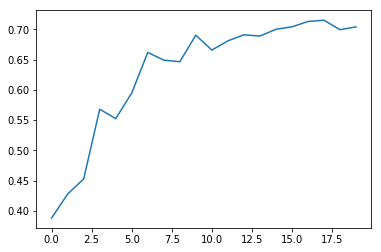

In [7]:
plt.plot(np.arange(len(acc_list)), acc_list)

In [10]:
def parse_args():
    args = argparse.Namespace()
    args.dataset = "cifar10"
    args.trainer = "ce"
    args.lr = 0.001
    args.arch = "CNN9c"
    args.iterations = 1000
    args.seed = 1
    args.size = 100
    args.no_cuda = False
    
    args.xi = 1e-6
    args.eps = 10
    args.k = 1
    args.use_entmin = False
    args.alpha = 1
    args.mom1 = 0.9
    args.mom2 = 0.5
    args.reg_lamb = 1
    
    args.gpu = 0

    args.log_dir = "log"
    args.n_categories = 10
    args.eval_freq = 1
    args.snapshot_freq = 20
    args.aug_flip = False
    args.aug_trans = False
    args.validation = False
    args.dataset_seed = 1
    args.batchsize = 32
    args.batchsize_ul = 128
    args.batchsize_eval = 100
    args.num_epochs = 200
    args.num_iter_per_epoch = 400
    args.epoch_decay_start = 120
    args.method = "ce"
    args.epsilon = 10
    args.extra_lamb = 1
    args.dropout_rate = 0.5
    args.top_bn = False
    args.vis = False

    args.data_dir = os.path.join("./data/%s" % args.dataset)

    chainer.global_config.cudnn_deterministic = True

    if int(args.gpu) > -1:
        print("use gpu")
        chainer.cuda.get_device(args.gpu).use()
    np.random.seed(args.seed)
    if cp is not None:
        cp.random.seed(args.seed)
    return args

arg = parse_args()
arg.exp = "avg"
wlog("args in this experiment %s", '\n'.join(str(e) for e in sorted(vars(arg).items())))
# noinspection PyBroadException

acc_list = train(arg)


2019-05-12 19:48:28,914 - <ipython-input-10-c4fceda30800>[line:58]: args in this experiment ('alpha', 1)
('arch', 'CNN9c')
('aug_flip', False)
('aug_trans', False)
('batchsize', 32)
('batchsize_eval', 100)
('batchsize_ul', 128)
('data_dir', './data/cifar10')
('dataset', 'cifar10')
('dataset_seed', 1)
('dropout_rate', 0.5)
('epoch_decay_start', 120)
('eps', 10)
('epsilon', 10)
('eval_freq', 1)
('exp', 'avg')
('extra_lamb', 1)
('gpu', 0)
('iterations', 1000)
('k', 1)
('log_dir', 'log')
('lr', 0.001)
('method', 'ce')
('mom1', 0.9)
('mom2', 0.5)
('n_categories', 10)
('no_cuda', False)
('num_epochs', 200)
('num_iter_per_epoch', 400)
('reg_lamb', 1)
('seed', 1)
('size', 100)
('snapshot_freq', 20)
('top_bn', False)
('trainer', 'ce')
('use_entmin', False)
('validation', False)
('vis', False)
('xi', 1e-06)


use gpu


2019-05-12 19:48:31,916 - <ipython-input-3-a821cc746a40>[line:3]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783


2019-05-12 19:48:52,638 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:0, iteration:400, nll loss:1.5222091674804688, unlabeled loss:0.0, time:18.000797986984253
2019-05-12 19:48:52,650 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.3158999979496002, error rate: 68.41000020503998
2019-05-12 19:49:13,299 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:1, iteration:800, nll loss:0.9993879795074463, unlabeled loss:0.0, time:20.779501914978027
2019-05-12 19:49:13,300 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.46790000796318054, error rate: 53.209999203681946
2019-05-12 19:49:34,433 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:2, iteration:1200, nll loss:0.7663781642913818, unlabeled loss:0.0, time:21.373563051223755
2019-05-12 19:49:34,434 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.5209000110626221, error rate: 47.90999889373779
2019-05-12 19:49:54,775 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:3, iteration:1600, nll loss:0.5876518487930298, unlabe

2019-05-12 19:59:48,191 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:28, iteration:11600, nll loss:0.03765348345041275, unlabeled loss:0.0, time:20.74920654296875
2019-05-12 19:59:48,198 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6863999962806702, error rate: 31.360000371932983
2019-05-12 20:00:09,140 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:29, iteration:12000, nll loss:0.03849917650222778, unlabeled loss:0.0, time:21.441784143447876
2019-05-12 20:00:09,141 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7080000042915344, error rate: 29.199999570846558
2019-05-12 20:00:32,663 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:30, iteration:12400, nll loss:0.028598766773939133, unlabeled loss:0.0, time:23.077910900115967
2019-05-12 20:00:32,664 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7075999975204468, error rate: 29.240000247955322
2019-05-12 20:00:52,960 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:31, iteration:12800, nll loss:0.0424159318

2019-05-12 20:10:40,079 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:56, iteration:22800, nll loss:0.006926071830093861, unlabeled loss:0.0, time:23.778284549713135
2019-05-12 20:10:40,081 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7271999716758728, error rate: 27.28000283241272
2019-05-12 20:11:01,239 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:57, iteration:23200, nll loss:0.025033727288246155, unlabeled loss:0.0, time:21.56192708015442
2019-05-12 20:11:01,253 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7074999809265137, error rate: 29.250001907348633
2019-05-12 20:11:24,443 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:58, iteration:23600, nll loss:0.019721880555152893, unlabeled loss:0.0, time:23.33305025100708
2019-05-12 20:11:24,444 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7354000210762024, error rate: 26.45999789237976
2019-05-12 20:11:48,134 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:59, iteration:24000, nll loss:0.01437115296

2019-05-12 20:21:41,933 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:84, iteration:34000, nll loss:0.010319472290575504, unlabeled loss:0.0, time:21.24325966835022
2019-05-12 20:21:41,946 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7253999710083008, error rate: 27.460002899169922
2019-05-12 20:22:02,551 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:85, iteration:34400, nll loss:0.008405918255448341, unlabeled loss:0.0, time:20.694038152694702
2019-05-12 20:22:02,553 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7208999991416931, error rate: 27.91000008583069
2019-05-12 20:22:24,368 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:86, iteration:34800, nll loss:0.01808484084904194, unlabeled loss:0.0, time:21.676950931549072
2019-05-12 20:22:24,382 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7253000140190125, error rate: 27.469998598098755
2019-05-12 20:22:47,606 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:87, iteration:35200, nll loss:0.0171424001

2019-05-12 20:32:27,005 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:112, iteration:45200, nll loss:0.018649371340870857, unlabeled loss:0.0, time:20.447105169296265
2019-05-12 20:32:27,010 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7398999929428101, error rate: 26.010000705718994
2019-05-12 20:32:49,278 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:113, iteration:45600, nll loss:0.004911070689558983, unlabeled loss:0.0, time:22.595394611358643
2019-05-12 20:32:49,280 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7366999983787537, error rate: 26.330000162124634
2019-05-12 20:33:15,609 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:114, iteration:46000, nll loss:0.014029882848262787, unlabeled loss:0.0, time:25.730783700942993
2019-05-12 20:33:15,610 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7379000186920166, error rate: 26.20999813079834
2019-05-12 20:33:42,223 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:115, iteration:46400, nll loss:0.0082

2019-05-12 20:43:30,173 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:140, iteration:56400, nll loss:0.003979036584496498, unlabeled loss:0.0, time:22.577624082565308
2019-05-12 20:43:30,186 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7418000102043152, error rate: 25.81999897956848
2019-05-12 20:43:51,748 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:141, iteration:56800, nll loss:0.00241109705530107, unlabeled loss:0.0, time:20.7958824634552
2019-05-12 20:43:51,752 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7423999905586243, error rate: 25.760000944137573
2019-05-12 20:44:13,222 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:142, iteration:57200, nll loss:0.0021883402951061726, unlabeled loss:0.0, time:21.668684482574463
2019-05-12 20:44:13,223 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7300000190734863, error rate: 26.999998092651367
2019-05-12 20:44:36,970 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:143, iteration:57600, nll loss:0.006401

2019-05-12 20:53:45,302 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:168, iteration:67600, nll loss:0.0015296777710318565, unlabeled loss:0.0, time:21.04483151435852
2019-05-12 20:53:45,303 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7459999918937683, error rate: 25.40000081062317
2019-05-12 20:54:06,816 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:169, iteration:68000, nll loss:0.0004896091413684189, unlabeled loss:0.0, time:21.82432746887207
2019-05-12 20:54:06,817 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7465000152587891, error rate: 25.349998474121094
2019-05-12 20:54:28,242 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:170, iteration:68400, nll loss:0.0009682959062047303, unlabeled loss:0.0, time:21.56581974029541
2019-05-12 20:54:28,246 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7372999787330627, error rate: 26.270002126693726
2019-05-12 20:54:51,469 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:171, iteration:68800, nll loss:0.0011

2019-05-12 21:03:29,531 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.756600022315979, error rate: 24.3399977684021
2019-05-12 21:03:49,155 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:196, iteration:78800, nll loss:0.00010476140596438199, unlabeled loss:0.0, time:19.44618320465088
2019-05-12 21:03:49,156 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7534999847412109, error rate: 24.650001525878906
2019-05-12 21:04:09,943 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:197, iteration:79200, nll loss:0.00022836157586425543, unlabeled loss:0.0, time:20.680588483810425
2019-05-12 21:04:09,949 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7563999891281128, error rate: 24.36000108718872
2019-05-12 21:04:29,032 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:198, iteration:79600, nll loss:8.856038766680285e-05, unlabeled loss:0.0, time:19.436713695526123
2019-05-12 21:04:29,034 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.7560999989509583, error rate: 2

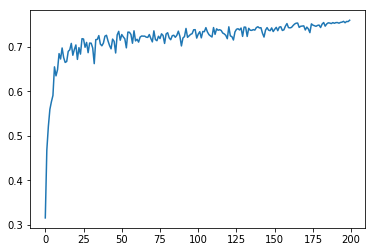

In [11]:
plt.plot(np.arange(len(acc_list)), acc_list)

In [12]:
acc_list

array([0.3159    , 0.46790001, 0.52090001, 0.55930001, 0.57639998,
       0.5905    , 0.65460002, 0.63440001, 0.64810002, 0.68430001,
       0.67220002, 0.69690001, 0.67559999, 0.6645    , 0.66659999,
       0.6893    , 0.69279999, 0.70719999, 0.68059999, 0.69349998,
       0.70370001, 0.67129999, 0.69770002, 0.6832    , 0.71780002,
       0.71700001, 0.69849998, 0.7094    , 0.6864    , 0.708     ,
       0.7076    , 0.69690001, 0.66180003, 0.71560001, 0.71609998,
       0.72469997, 0.70569998, 0.70179999, 0.708     , 0.7234    ,
       0.72539997, 0.71289998, 0.70240003, 0.69499999, 0.71679997,
       0.71179998, 0.6857    , 0.72610003, 0.7342    , 0.71429998,
       0.727     , 0.72180003, 0.71740001, 0.6972    , 0.73250002,
       0.73220003, 0.72719997, 0.70749998, 0.73540002, 0.71280003,
       0.71649998, 0.7101    , 0.72140002, 0.7238    , 0.7234    ,
       0.72350001, 0.72119999, 0.72070003, 0.727     , 0.71829998,
       0.71060002, 0.7353    , 0.71579999, 0.71319997, 0.72320

In [8]:

arg.dropout_rate = 0.0
wlog("args in this experiment %s", '\n'.join(str(e) for e in sorted(vars(arg).items())))
# noinspection PyBroadException

acc_z_list = train(arg)


2019-05-12 18:48:39,582 - <ipython-input-8-6c0babd046f4>[line:3]: args in this experiment ('alpha', 1)
('arch', 'CNN9c')
('aug_flip', False)
('aug_trans', False)
('batchsize', 32)
('batchsize_eval', 100)
('batchsize_ul', 128)
('data_dir', './data/cifar10')
('dataset', 'cifar10')
('dataset_seed', 1)
('dropout_rate', 0.0)
('epoch_decay_start', 0)
('eps', 10)
('epsilon', 10)
('eval_freq', 1)
('exp', 'avg')
('extra_lamb', 1)
('gpu', 0)
('iterations', 1000)
('k', 1)
('log_dir', 'log')
('lr', 0.001)
('method', 'ce')
('mom1', 0.9)
('mom2', 0.5)
('n_categories', 10)
('no_cuda', False)
('num_epochs', 20)
('num_iter_per_epoch', 400)
('reg_lamb', 1)
('seed', 1)
('size', 100)
('snapshot_freq', 20)
('top_bn', False)
('trainer', 'ce')
('use_entmin', False)
('validation', False)
('vis', False)
('xi', 1e-06)
2019-05-12 18:48:42,983 - <ipython-input-3-a821cc746a40>[line:3]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783


2019-05-12 18:49:08,749 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:0, iteration:400, nll loss:1.1521999835968018, unlabeled loss:0.0, time:23.470928192138672
2019-05-12 18:49:08,750 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.37770000100135803, error rate: 62.2299998998642
2019-05-12 18:49:33,785 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:1, iteration:800, nll loss:0.31475499272346497, unlabeled loss:0.0, time:24.770472764968872
2019-05-12 18:49:33,797 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.21449999511241913, error rate: 78.55000048875809
2019-05-12 18:49:56,381 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:2, iteration:1200, nll loss:0.0652083232998848, unlabeled loss:0.0, time:22.64548420906067
2019-05-12 18:49:56,382 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.5803999900817871, error rate: 41.96000099182129
2019-05-12 18:50:19,760 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:3, iteration:1600, nll loss:0.008678236976265907, unlab

array([0.3777    , 0.2145    , 0.58039999, 0.61210001, 0.66060001,
       0.65609998, 0.66119999, 0.66119999, 0.6584    , 0.66039997,
       0.66289997, 0.66369998, 0.65869999, 0.65859997, 0.662     ,
       0.66420001, 0.66189998, 0.65789998, 0.65920001, 0.66289997])

In [13]:

arg.dropout_rate = 0.0
wlog("args in this experiment %s", '\n'.join(str(e) for e in sorted(vars(arg).items())))
# noinspection PyBroadException

acc_z_list = train(arg)


2019-05-12 21:13:58,014 - <ipython-input-13-485bd32e7ed9>[line:3]: args in this experiment ('alpha', 1)
('arch', 'CNN9c')
('aug_flip', False)
('aug_trans', False)
('batchsize', 32)
('batchsize_eval', 100)
('batchsize_ul', 128)
('data_dir', './data/cifar10')
('dataset', 'cifar10')
('dataset_seed', 1)
('dropout_rate', 0.0)
('epoch_decay_start', 120)
('eps', 10)
('epsilon', 10)
('eval_freq', 1)
('exp', 'avg')
('extra_lamb', 1)
('gpu', 0)
('iterations', 1000)
('k', 1)
('log_dir', 'log')
('lr', 0.001)
('method', 'ce')
('mom1', 0.9)
('mom2', 0.5)
('n_categories', 10)
('no_cuda', False)
('num_epochs', 200)
('num_iter_per_epoch', 400)
('reg_lamb', 1)
('seed', 1)
('size', 100)
('snapshot_freq', 20)
('top_bn', False)
('trainer', 'ce')
('use_entmin', False)
('validation', False)
('vis', False)
('xi', 1e-06)
2019-05-12 21:14:00,733 - <ipython-input-3-a821cc746a40>[line:3]: N_train_labeled:4000, N_train_unlabeled:50000


train data -2591.2783


2019-05-12 21:14:20,294 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:0, iteration:400, nll loss:1.2077839374542236, unlabeled loss:0.0, time:17.049859523773193
2019-05-12 21:14:20,296 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.400299996137619, error rate: 59.9700003862381
2019-05-12 21:14:41,362 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:1, iteration:800, nll loss:0.41610488295555115, unlabeled loss:0.0, time:21.094951391220093
2019-05-12 21:14:41,369 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.47040000557899475, error rate: 52.959999442100525
2019-05-12 21:15:06,700 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:2, iteration:1200, nll loss:0.10882772505283356, unlabeled loss:0.0, time:25.156887531280518
2019-05-12 21:15:06,701 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.36079999804496765, error rate: 63.920000195503235
2019-05-12 21:15:32,981 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:3, iteration:1600, nll loss:0.05028672516345978, unl

2019-05-12 21:24:36,185 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:28, iteration:11600, nll loss:0.00010361615568399429, unlabeled loss:0.0, time:20.136436939239502
2019-05-12 21:24:36,199 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6700999736785889, error rate: 32.99000263214111
2019-05-12 21:24:58,550 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:29, iteration:12000, nll loss:9.827278699958697e-05, unlabeled loss:0.0, time:22.231157541275024
2019-05-12 21:24:58,560 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6697999835014343, error rate: 33.02000164985657
2019-05-12 21:25:24,805 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:30, iteration:12400, nll loss:8.177474228432402e-05, unlabeled loss:0.0, time:26.29404640197754
2019-05-12 21:25:24,806 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6736000180244446, error rate: 32.63999819755554
2019-05-12 21:25:50,113 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:31, iteration:12800, nll loss:6.1436112

2019-05-12 21:34:41,783 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:56, iteration:22800, nll loss:4.96102511533536e-05, unlabeled loss:0.0, time:21.334256649017334
2019-05-12 21:34:41,795 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6751000285148621, error rate: 32.489997148513794
2019-05-12 21:35:03,830 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:57, iteration:23200, nll loss:3.581535202101804e-05, unlabeled loss:0.0, time:22.207225561141968
2019-05-12 21:35:03,834 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6722000241279602, error rate: 32.77999758720398
2019-05-12 21:35:28,524 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:58, iteration:23600, nll loss:4.1107759898295626e-05, unlabeled loss:0.0, time:24.52443552017212
2019-05-12 21:35:28,546 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6743000149726868, error rate: 32.56999850273132
2019-05-12 21:35:52,895 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:59, iteration:24000, nll loss:2.8588734

2019-05-12 21:45:24,522 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:84, iteration:34000, nll loss:7.512111187679693e-05, unlabeled loss:0.0, time:23.351277589797974
2019-05-12 21:45:24,527 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6703000068664551, error rate: 32.96999931335449
2019-05-12 21:45:52,205 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:85, iteration:34400, nll loss:7.051553257042542e-05, unlabeled loss:0.0, time:27.27179789543152
2019-05-12 21:45:52,207 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6671000123023987, error rate: 33.28999876976013
2019-05-12 21:46:18,725 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:86, iteration:34800, nll loss:6.798148388043046e-05, unlabeled loss:0.0, time:26.71100354194641
2019-05-12 21:46:18,726 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6712999939918518, error rate: 32.87000060081482
2019-05-12 21:46:47,389 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:87, iteration:35200, nll loss:3.935888526

2019-05-12 21:55:32,382 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:112, iteration:45200, nll loss:0.0518907867372036, unlabeled loss:0.0, time:22.015848398208618
2019-05-12 21:55:32,383 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6200000047683716, error rate: 37.99999952316284
2019-05-12 21:55:54,308 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:113, iteration:45600, nll loss:0.008424055762588978, unlabeled loss:0.0, time:21.66033673286438
2019-05-12 21:55:54,310 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6513000130653381, error rate: 34.86999869346619
2019-05-12 21:56:13,539 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:114, iteration:46000, nll loss:0.0024609973188489676, unlabeled loss:0.0, time:19.378793954849243
2019-05-12 21:56:13,543 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6585999727249146, error rate: 34.140002727508545
2019-05-12 21:56:33,257 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:115, iteration:46400, nll loss:0.0006291

2019-05-12 22:04:19,467 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:140, iteration:56400, nll loss:0.03409602493047714, unlabeled loss:0.0, time:19.918277502059937
2019-05-12 22:04:19,474 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6432999968528748, error rate: 35.670000314712524
2019-05-12 22:04:40,030 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:141, iteration:56800, nll loss:0.001471406314522028, unlabeled loss:0.0, time:20.671972274780273
2019-05-12 22:04:40,035 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6599000096321106, error rate: 34.00999903678894
2019-05-12 22:05:03,300 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:142, iteration:57200, nll loss:0.0005108736804686487, unlabeled loss:0.0, time:23.129817008972168
2019-05-12 22:05:03,306 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6586999893188477, error rate: 34.130001068115234
2019-05-12 22:05:24,684 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:143, iteration:57600, nll loss:0.0003

2019-05-12 22:13:29,874 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:168, iteration:67600, nll loss:3.440205182414502e-05, unlabeled loss:0.0, time:20.646077632904053
2019-05-12 22:13:29,878 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6617000102996826, error rate: 33.82999897003174
2019-05-12 22:13:50,217 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:169, iteration:68000, nll loss:2.8358175768516958e-05, unlabeled loss:0.0, time:20.115401029586792
2019-05-12 22:13:50,218 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6632999777793884, error rate: 33.67000222206116
2019-05-12 22:14:07,706 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:170, iteration:68400, nll loss:1.9735507521545514e-05, unlabeled loss:0.0, time:17.62958788871765
2019-05-12 22:14:07,707 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6607000231742859, error rate: 33.92999768257141
2019-05-12 22:14:25,074 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:171, iteration:68800, nll loss:2.02

2019-05-12 22:22:27,058 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:196, iteration:78800, nll loss:7.151216323109111e-06, unlabeled loss:0.0, time:18.409916877746582
2019-05-12 22:22:27,059 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6625999808311462, error rate: 33.740001916885376
2019-05-12 22:22:43,962 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:197, iteration:79200, nll loss:5.1328538575035054e-06, unlabeled loss:0.0, time:16.99038815498352
2019-05-12 22:22:43,964 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6651999950408936, error rate: 33.480000495910645
2019-05-12 22:23:01,125 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:198, iteration:79600, nll loss:4.028417151857866e-06, unlabeled loss:0.0, time:17.1026930809021
2019-05-12 22:23:01,126 - <ipython-input-3-a821cc746a40>[line:67]: test acc:0.6660000085830688, error rate: 33.399999141693115
2019-05-12 22:23:18,393 - <ipython-input-3-a821cc746a40>[line:66]: Epoch:199, iteration:80000, nll loss:4.83

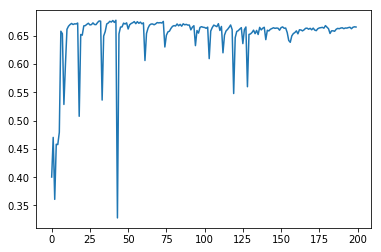

In [15]:
plt.plot(np.arange(len(acc_z_list)), acc_z_list)

In [14]:
acc_z_list

array([0.4003    , 0.47040001, 0.3608    , 0.45829999, 0.45770001,
       0.47940001, 0.65820003, 0.65380001, 0.52869999, 0.59899998,
       0.66159999, 0.667     , 0.6699    , 0.67189997, 0.67000002,
       0.67129999, 0.671     , 0.67269999, 0.50770003, 0.65240002,
       0.6512    , 0.66759998, 0.6681    , 0.67040002, 0.67229998,
       0.66930002, 0.6699    , 0.67290002, 0.67009997, 0.66979998,
       0.67360002, 0.67629999, 0.676     , 0.53640002, 0.64969999,
       0.65750003, 0.671     , 0.67269999, 0.67570001, 0.67439997,
       0.6771    , 0.67369998, 0.67760003, 0.32800001, 0.6534    ,
       0.66549999, 0.66579998, 0.67250001, 0.67089999, 0.67299998,
       0.66210002, 0.66960001, 0.67189997, 0.67320001, 0.67519999,
       0.67150003, 0.67510003, 0.67220002, 0.67430001, 0.67129999,
       0.67299998, 0.60640001, 0.6541    , 0.66360003, 0.66900003,
       0.67089999, 0.671     , 0.66960001, 0.67119998, 0.6735    ,
       0.67290002, 0.67339998, 0.67269999, 0.67549998, 0.63029